# 

In [15]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from arch import arch_model

In [20]:
ticker_symbol = 'CL=F'
start = '2015-01-01'
end = '2024-06-02'

In [21]:
data = yf.download(ticker_symbol, start, end)
data = data[['Close']]



[*********************100%%**********************]  1 of 1 completed


In [23]:
data = data[['Close']].resample('W').last()

In [24]:
data.rename(columns={'Close': 'Price'}, inplace=True)

In [40]:
# Identify the period from June to December in election years
election_years = [2020, 2016, 2012, 2008, 2004, 2000]
election_periods = [(f'{year}-06-01', f'{year}-12-31') for year in election_years]

In [41]:
volatilities = []
for start, end in election_periods:
    period_data = yf.download(ticker_symbol, start=start, end=end)
    period_data = period_data[['Close']].resample('W').last()
    period_data['Price'] = period_data['Close']
    period_data['pct_change'] = period_data['Price'].pct_change().dropna()
    volatilities.append(period_data['pct_change'].std())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [42]:
average_volatility = np.mean(volatilities)

In [43]:
data['Returns'] = data['Price'].pct_change().dropna()

In [44]:
# Standardize returns
returns_mean = data['Returns'].mean()
returns_std = data['Returns'].std()
data['Returns_Standardized'] = (data['Returns'] - returns_mean) / returns_std

In [45]:
# Fit the GARCH model with t-distribution
model = arch_model(data['Returns_Standardized'].dropna(), vol='Garch', p=1, q=1, dist='StudentsT')
garch_fit = model.fit(disp='off')

In [47]:
forecast_volatility = np.sqrt(forecast_variance)

In [46]:
# Forecast future volatility and standardized returns
forecast_steps = (pd.to_datetime('2025-01-01') - data.index[-1]).days // 7 + 1
garch_forecast = garch_fit.forecast(horizon=forecast_steps)
forecast_variance = garch_forecast.variance.iloc[-1].values
forecast_mean = garch_forecast.mean.iloc[-1].values

In [48]:
np.random.seed(42)
forecast_returns_standardized = np.random.standard_t(df=garch_fit.params['nu'], size=forecast_steps) * forecast_volatility

In [49]:
# Convert standardized returns back to original scale
forecast_returns = forecast_returns_standardized * returns_std + returns_mean

In [50]:
# Calculate forecast prices
last_price = data['Price'].iloc[-1]
forecast_prices = [last_price * (1 + r) for r in forecast_returns]

In [51]:
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')
forecast_df = pd.DataFrame(data=forecast_prices, index=forecast_index, columns=['ForecastPrice'])

In [52]:
adjusted_forecast_prices = forecast_df['ForecastPrice'] * (1 + average_volatility)

In [53]:
combined_prices = pd.concat([data['Price'], adjusted_forecast_prices])

In [54]:
combined_prices = combined_prices[combined_prices.index >= '2024-01-01']

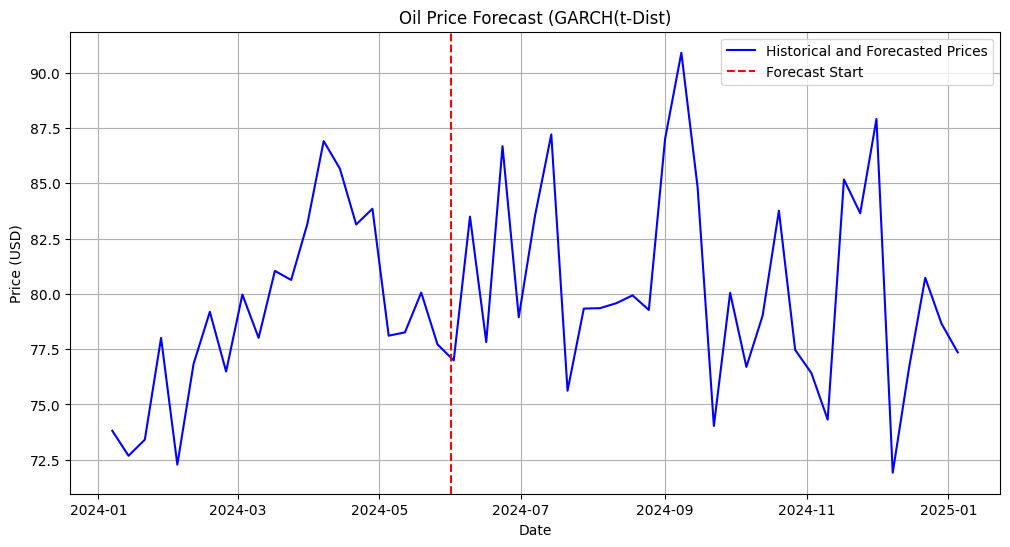

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(combined_prices.index, combined_prices, label='Historical and Forecasted Prices', color='blue')
plt.axvline(x=pd.to_datetime('2024-06-01'), color='red', linestyle='--', label='Forecast Start')
plt.title('Oil Price Forecast (GARCH(t-Dist)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('oil_price_forecast.jpg', format='jpg')
